# 

# Store Sales Forecasting 

Welcome to the Store Sales Forecasting project! In this notebook, we explore how to combine classical machine learning techniques with advanced feature engineering to build a high-quality sales prediction model. 

Leveraging the power of a Reasoning Model (o3-mini), we enrich the dataset with meaningful features to boost prediction accuracy. The dataset, sourced from [Kaggle's Store Sales Time Series Forecasting competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data), includes rich information such as dates, store and product details, promotional activities, and historical sales data.

Join us as we dive into this exciting journey of data exploration, feature engineering, and model building to unlock actionable insights for sales forecasting!

## Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True, precision=8)
pd.options.mode.chained_assignment = None

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_squared_log_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import FuncFormatter

from catboost import CatBoostRegressor
from tqdm import tqdm


# Set option to display all columns (None means no limit to the number of columns displayed)
pd.set_option("display.max_columns", None)

## Load data

In [ ]:
import os

# Get the current working directory
current_path = os.getcwd()
print(f"Current working directory: {current_path}")

Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/lubraz-reasoning-model/code


In [ ]:
holidays_events_df = pd.read_csv("../train/data/holidays_events.csv")
oil_df = pd.read_csv("../train/data/oil.csv")
stores_df = pd.read_csv("../train/data/stores.csv")
transactions_df = pd.read_csv("../train/data/transactions.csv")

train_df = pd.read_csv("../train/data/train.csv", index_col=False)
test_df = pd.read_csv("../train/data/test.csv", index_col=False)

test_df_original = test_df.copy()

## Preprocessing

In the Preprocessing section, we clean and prepare the data for analysis and modeling. 

This includes handling missing values, merging datasets, creating new features, and ensuring the data is in the correct format. These steps are crucial to ensure the quality and consistency of the data, which directly impacts the performance of the machine learning models.

In [4]:
def return_nan(df):
    # Count the number of NaN values in each column
    nan_counts = df.isna().sum()

    # Print the counts
    print(f"Number of rows in dataframe is: {len(df)}")
    print(nan_counts)


def count_nan_values(df: pd.DataFrame) -> dict:
    """
    This function takes a DataFrame and returns a dictionary where the keys are the column names
    and the values are the number of NaN values in each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    dict: A dictionary with column names as keys and the number of NaN values as values.
    """
    nan_count_dict = df.isna().sum().to_dict()
    return nan_count_dict


def plot_two_cols(df, col_1, col_2):
    """
    Plots date vs dcoilwtico from the given DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'date' and 'dcoilwtico' columns.

    """

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(df[col_1], df[col_2], marker="o", linestyle="-")
    plt.xlabel(col_1)
    plt.ylabel(col_2)
    plt.title(f"{col_1} vs {col_2}")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Dates
def date_breakdown(df):
    # Ensure the 'date' column is in datetime format
    df["date"] = pd.to_datetime(df["date"])

    df["weekday"] = df["date"].dt.dayofweek
    df["weekday_name"] = df["date"].dt.strftime("%A")
    df["month"] = df["date"].dt.month
    df["month_name"] = df["date"].dt.strftime("%B")
    df["quarter"] = df["date"].dt.quarter
    df["year"] = df["date"].dt.year
    df["week_of_year"] = df["date"].dt.isocalendar().week
    df["day_of_year"] = df["date"].dt.dayofyear

    return df

# Fill in date columns
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])
holidays_events_df["date"] = pd.to_datetime(holidays_events_df["date"])

train_df = train_df.sort_values(by="date", ascending=True)
test_df = test_df.sort_values(by="date", ascending=True)
oil_df = oil_df.sort_values(by="date", ascending=True)
holidays_events_df = holidays_events_df.sort_values(by="date", ascending=True)

# Add train/test bool
train_df["test"] = 0
test_df["test"] = 1

combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df = date_breakdown(combined_df)

print(f"NaN values in Train DF: {count_nan_values(train_df)}")
print(f"NaN values in Test DF: {count_nan_values(test_df)}")
print(f"NaN values in Oil DF: {count_nan_values(oil_df)}")
print(f"NaN values in Holidays DF: {count_nan_values(holidays_events_df)}")
print(f"NaN values in Transactions DF: {count_nan_values(transactions_df)}")
print('\n')
print('\n')

# Check completeness of train
min_date = train_df["date"].min()
max_date = test_df["date"].max()

print(f"Minimum training date: {min_date}")
print(f"Maximum training date: {max_date}")
print('\n')
print('\n')

# Get a list of all date ranges
expected_dates = pd.date_range(start=min_date, end=max_date)


def count_missing_dates_with_non_nan(expected_dates, oil_df):
    # Convert expected_dates to a DataFrame
    expected_df = pd.DataFrame({"date": expected_dates})

    # Merge with oil_df to find missing dates and NaN values
    merged_df = expected_df.merge(oil_df, on="date", how="left")

    # Count dates that are either missing or have NaN values in dcoilwtico
    missing_count = merged_df["dcoilwtico"].isna().sum()

    print(
        f"Number of dates in expected_dates not in oil_df with a non-NaN value: {missing_count}"
    )
    return missing_count


def ensure_dates_in_df(oil_df, date_list):
    # Ensure date column is in datetime format
    oil_df["date"] = pd.to_datetime(oil_df["date"])
    date_list = pd.to_datetime(date_list)

    # Create a set of dates that need to be in the dataframe
    date_set = set(date_list)

    # Get the existing dates in the dataframe
    existing_dates = set(oil_df["date"])

    # Find the missing dates
    missing_dates = date_set - existing_dates

    # Create a new dataframe with the missing dates and NaN values for dcoilwtico
    missing_df = pd.DataFrame({"date": list(missing_dates), "dcoilwtico": np.nan})

    # Concatenate the missing dates to the original dataframe
    oil_df = pd.concat([oil_df, missing_df], ignore_index=True)

    # Sort the dataframe by date
    oil_df = oil_df.sort_values(by="date").reset_index(drop=True)

    return oil_df


def fill_na_with_next_value(oil_df):
    # Ensure the dataframe is sorted by date
    oil_df = oil_df.sort_values(by="date").reset_index(drop=True)

    # Get the indices where dcoilwtico is NaN
    nan_indices = oil_df[oil_df["dcoilwtico"].isna()].index

    for idx in nan_indices:
        # Find the next non-NaN value
        next_valid_index = oil_df.loc[idx:].dropna(subset=["dcoilwtico"]).index[0]
        next_valid_value = oil_df.at[next_valid_index, "dcoilwtico"]

        # Replace NaN with the next non-NaN value
        oil_df.at[idx, "dcoilwtico"] = next_valid_value

    return oil_df


# Check all dates are present
count_missing_dates_with_non_nan(expected_dates, oil_df)

# Add missing dates
oil_df = ensure_dates_in_df(oil_df, expected_dates)

# Fill in NaNs
oil_df = fill_na_with_next_value(oil_df)

# Check all dates are present
count_missing_dates_with_non_nan(expected_dates, oil_df)

# Merge dataframes
combined_df = combined_df.merge(stores_df, on="store_nbr", how="left")
combined_df = combined_df.merge(oil_df, on="date", how="left")

# Convert 'date' columns to datetime in both dataframes
combined_df["date"] = pd.to_datetime(combined_df["date"])
transactions_df["date"] = pd.to_datetime(transactions_df["date"])

# Now perform the merge
combined_df = combined_df.merge(transactions_df, on=["date", "store_nbr"], how="left")

# Change type_x and type_y
combined_df.rename(columns={"type": "store_type"}, inplace=True)

train_df = combined_df[combined_df["test"] == 0]
test_df = combined_df[combined_df["test"] == 1]

# Combined
combined_df.drop(columns=["transactions"], inplace=True)

def print_unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Column '{column}' has the following unique values:")
        print(unique_values)
        print("\n")


def fill_na_with_value(
    df: pd.DataFrame, columns: list, value: str = "No Holiday"
) -> pd.DataFrame:
    """
    Fill NaN values with a specified value in given columns of a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe to operate on.
    columns (list): List of column names to fill NaN values in.
    value (str): The value to fill NaN values with. Default is "No Holiday".

    Returns:
    pd.DataFrame: The dataframe with NaN values filled.
    """
    for column in columns:
        if column in df.columns:
            df[column].fillna(value, inplace=True)

    return df

columns_to_fill = [
    "holiday_type",
    "locale",
    "locale_name",
    "description",
    "transferred",
]

combined_df = fill_na_with_value(combined_df, columns_to_fill, value="No Holiday")

train_df = combined_df[combined_df["test"] == 0]
test_df = combined_df[combined_df["test"] == 1]

# Check for duplicates
def check_duplicate_rows(df):

    # Group by the specified columns and count the occurrences
    grouped = (
        df.groupby(["date", "store_nbr", "family"]).size().reset_index(name="count")
    )

    # Filter to only include rows with counts greater than 1
    duplicates = grouped[grouped["count"] > 1]

    return duplicates


def check_duplicates_with_sales(df):
    # Find duplicate rows based on 'date', 'store_nbr', and 'family'
    duplicates = df[df.duplicated(subset=["date", "store_nbr", "family"], keep=False)]

    # Group by 'date', 'store_nbr', and 'family'
    grouped_duplicates = duplicates.groupby(["date", "store_nbr", "family"])

    # Check for different sales values within each group
    for _, group in grouped_duplicates:
        if group["sales"].nunique() > 1:
            print(list(group.index))

def remove_duplicates_keep_first(df):
    # Remove duplicated rows based on 'date', 'store_nbr', and 'family', keeping the first instance
    deduplicated_df = df.drop_duplicates(
        subset=["date", "store_nbr", "family"], keep="first"
    )

    # Reset the index of the DataFrame
    # deduplicated_df = deduplicated_df.reset_index(drop=True)

    return deduplicated_df

print(f"Length of combined_df pre duplication {len(combined_df)}")
combined_df = remove_duplicates_keep_first(combined_df)
print(f"Length of combined_df post duplication {len(combined_df)}")
print('\n')
print('\n')

check_duplicate_rows(combined_df)

train_df = combined_df[combined_df["test"] == 0]
test_df = combined_df[combined_df["test"] == 1]

print(f"Length of training set {len(train_df)}")
print(f"Length of test set {len(test_df)}")
print('\n')
print('\n')

# ------ save combined_df -----
combined_df_saved = combined_df.copy()

NaN values in Train DF: {'id': 0, 'date': 0, 'store_nbr': 0, 'family': 0, 'sales': 0, 'onpromotion': 0, 'test': 0}
NaN values in Test DF: {'id': 0, 'date': 0, 'store_nbr': 0, 'family': 0, 'onpromotion': 0, 'test': 0}
NaN values in Oil DF: {'date': 0, 'dcoilwtico': 43}
NaN values in Holidays DF: {'date': 0, 'type': 0, 'locale': 0, 'locale_name': 0, 'description': 0, 'transferred': 0}
NaN values in Transactions DF: {'date': 0, 'store_nbr': 0, 'transactions': 0}




Minimum training date: 2013-01-01 00:00:00
Maximum training date: 2017-08-31 00:00:00




Number of dates in expected_dates not in oil_df with a non-NaN value: 529
Number of dates in expected_dates not in oil_df with a non-NaN value: 0
Length of combined_df pre duplication 3029400
Length of combined_df post duplication 3029400




Length of training set 3000888
Length of test set 28512






## EDA

### Relation to Sales

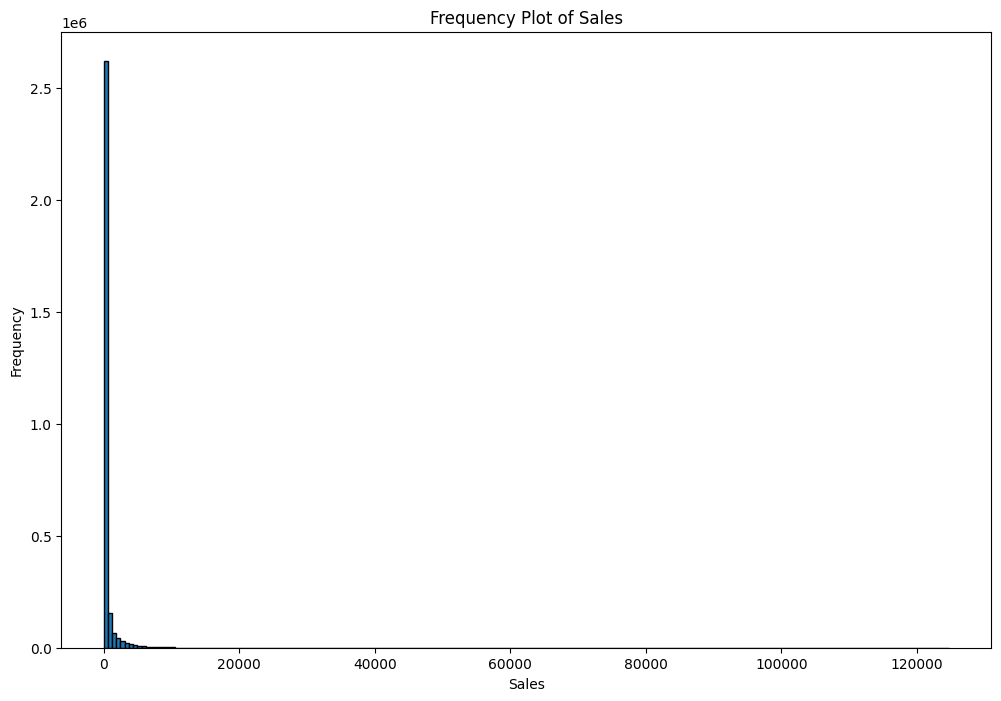

In [5]:
# Plotting the frequency plot
plt.figure(figsize=(12, 8))
plt.hist(train_df["sales"], bins=200, edgecolor="black")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title("Frequency Plot of Sales")
plt.show()

### Daily sales

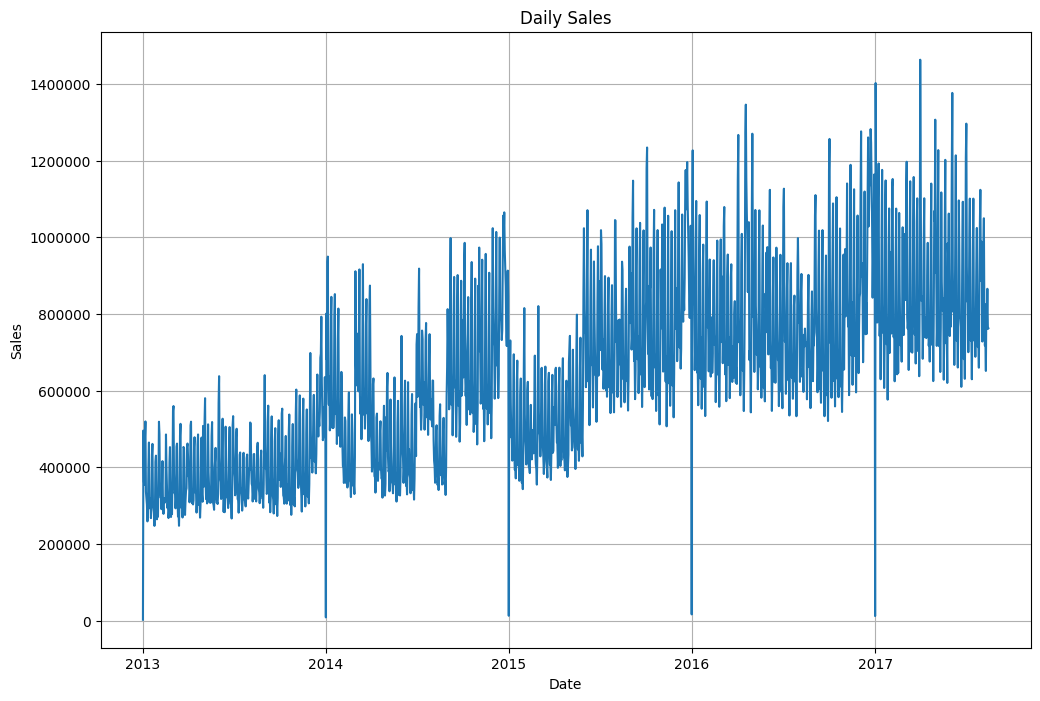

In [ ]:
# Ensure the date column is in datetime format
train_df["date"] = pd.to_datetime(train_df["date"])

# Aggregate sales per day
daily_sales = train_df.groupby("date")["sales"].sum().reset_index()


# Function to format the y-axis labels
def millions(x, pos):
    "The two args are the value and tick position"
    return "%1.0f" % x


formatter = FuncFormatter(millions)

# Plotting the data
plt.figure(figsize=(12, 8))
plt.plot(daily_sales["date"], daily_sales["sales"])
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

### Daily average sales per Store

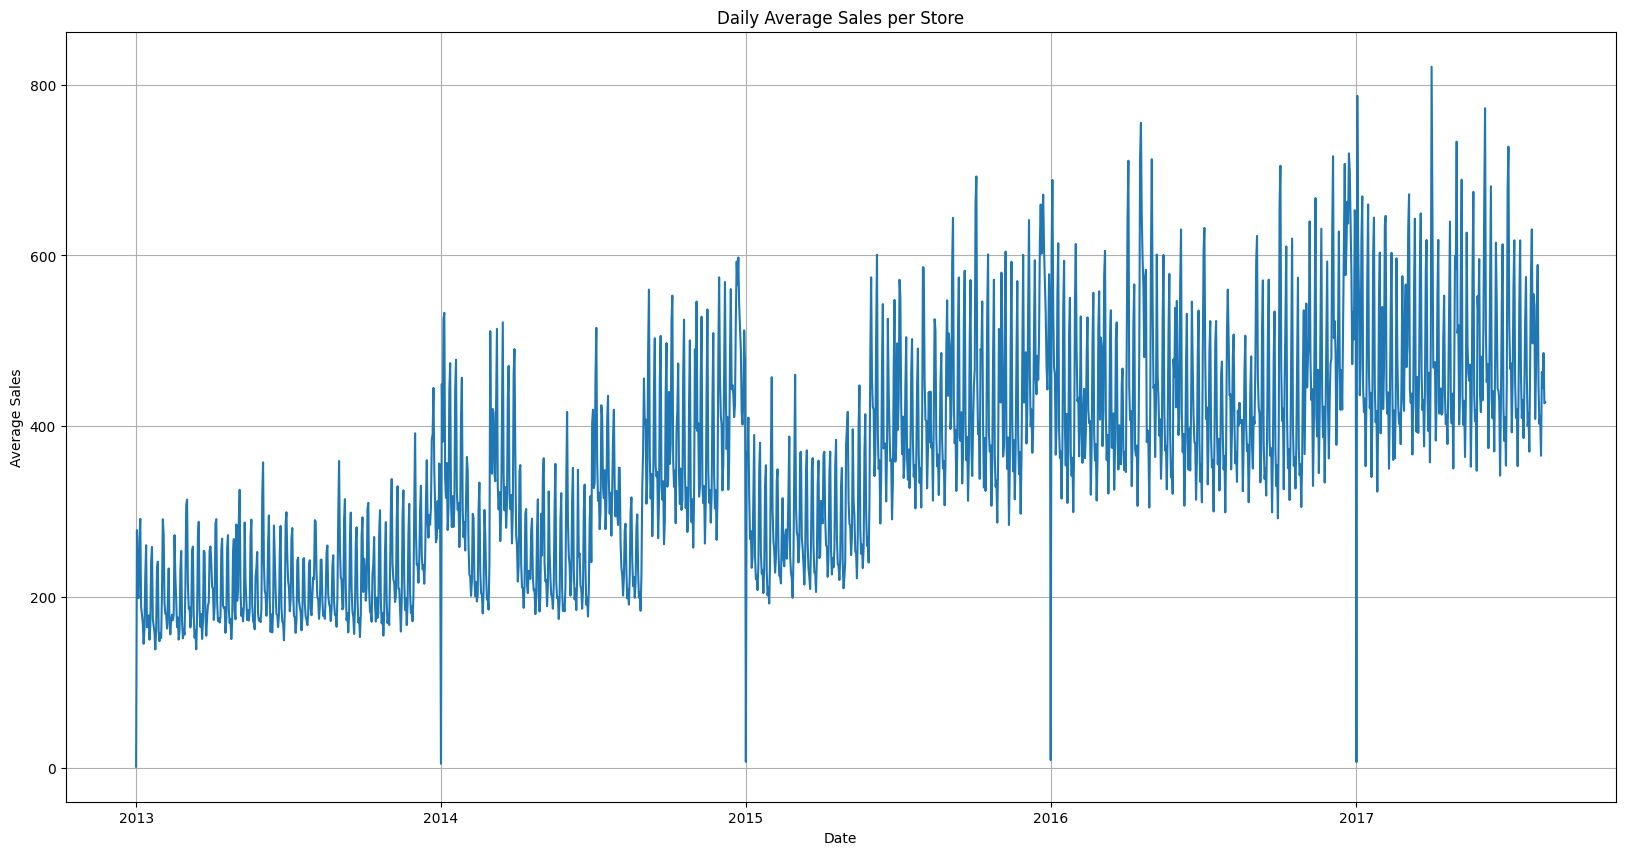

In [7]:
# Ensure the date column is in datetime format
train_df["date"] = pd.to_datetime(train_df["date"])

# Aggregate average sales per store per day
average_sales_per_store_daily = (
    train_df.groupby(["date", "store_nbr"])["sales"].mean().reset_index()
)
daily_average_sales = (
    average_sales_per_store_daily.groupby("date")["sales"].mean().reset_index()
)


# Function to format the y-axis labels
def millions(x, pos):
    "The two args are the value and tick position"
    return "%1.0f" % x


formatter = FuncFormatter(millions)

# Plotting the data
plt.figure(figsize=(20, 10))
plt.plot(daily_average_sales["date"], daily_average_sales["sales"])
plt.title("Daily Average Sales per Store")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

# Feature Engineering

Feature engineering is a critical step in the data preparation process, where we create new features or transform existing ones to enhance the predictive power of machine learning models. In this section, we perform various feature engineering tasks, including adding lagged features, calculating rolling averages, and creating specific day sales averages. These features help capture temporal patterns, seasonality, and other trends in the data, enabling the models to make more accurate predictions.

### Scale continuous values

In [ ]:
combined_df = combined_df_saved.copy()

def convert_columns_to_categorical(df, columns):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].astype("category")

    #     for column in df.columns:
    #         print(f"Column: {column}, Type: {df[column].dtype}")

    return df

# Scale continuous values
scaler = StandardScaler()
continous_features = ["dcoilwtico"]
combined_df[continous_features] = scaler.fit_transform(combined_df[continous_features])

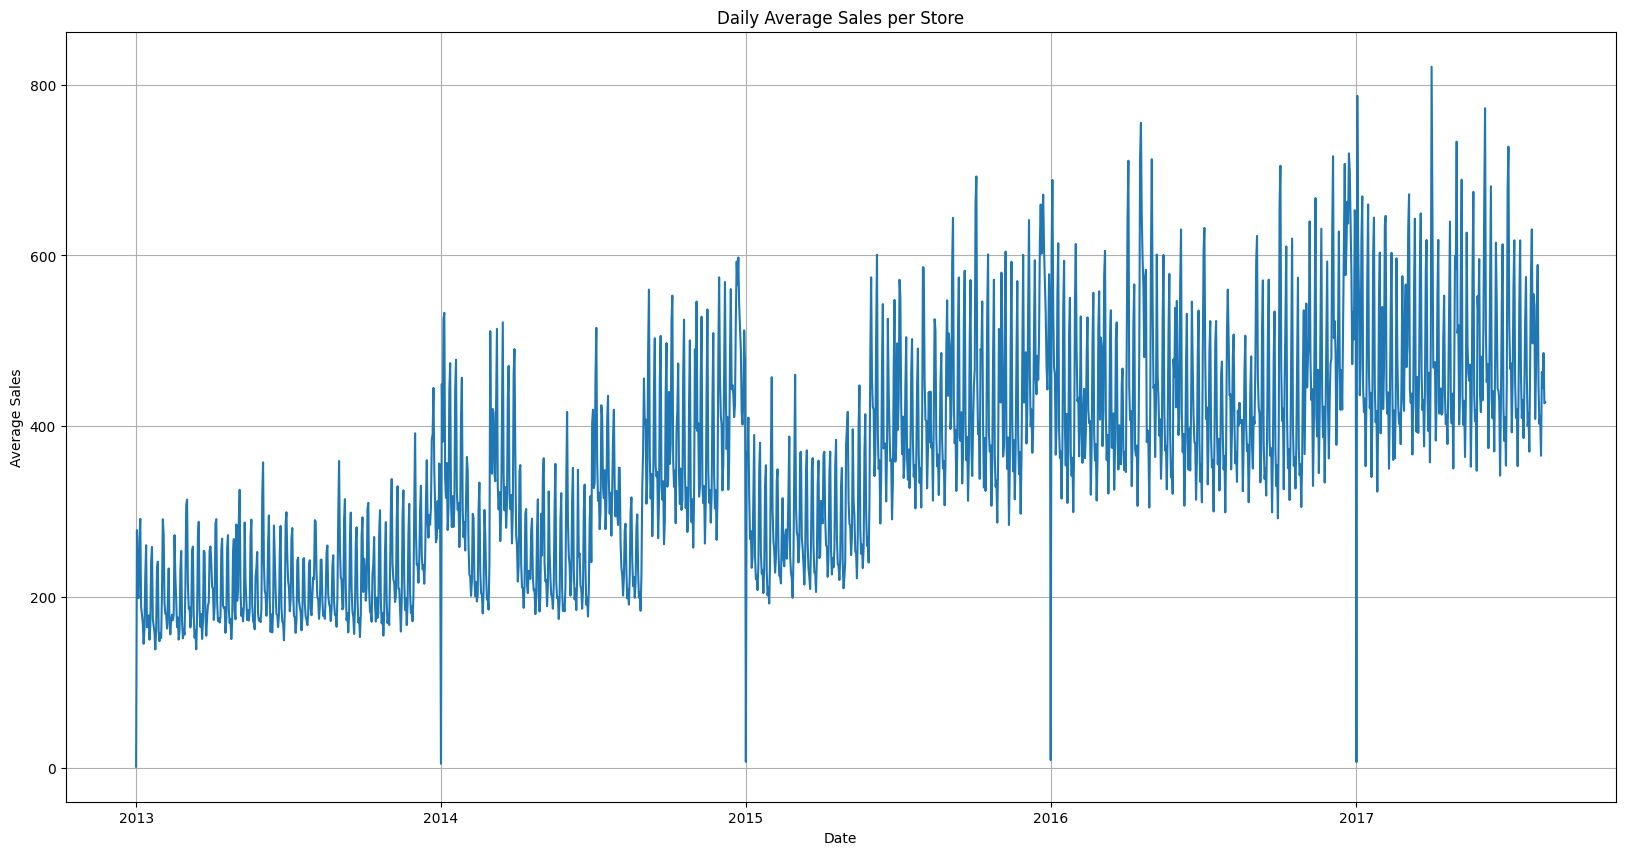

In [9]:
# Ensure the date column is in datetime format
train_df["date"] = pd.to_datetime(train_df["date"])

# Aggregate average sales per store per day
average_sales_per_store_daily = (
    train_df.groupby(["date", "store_nbr"])["sales"].mean().reset_index()
)
daily_average_sales = (
    average_sales_per_store_daily.groupby("date")["sales"].mean().reset_index()
)


# Function to format the y-axis labels
def millions(x, pos):
    "The two args are the value and tick position"
    return "%1.0f" % x


formatter = FuncFormatter(millions)

# Plotting the data
plt.figure(figsize=(20, 10))
plt.plot(daily_average_sales["date"], daily_average_sales["sales"])
plt.title("Daily Average Sales per Store")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

### Adding Lagged Features

In [10]:
def add_lagged_features(df):

    # Create copy of df to work with
    df_copy = df.copy()

    # Ensure the date column is in datetime format
    df_copy["date"] = pd.to_datetime(df_copy["date"])

    # Sort by date for each store_nbr and family combination
    df_copy = df_copy.sort_values(by=["store_nbr", "family", "date"])

    # Set multi-index for easier group operations
    df_copy.set_index(["store_nbr", "family", "date"], inplace=True)

    # Lagged features
    df_copy["sales_lag_21"] = df_copy.groupby(["store_nbr", "family"])["sales"].shift(
        21
    )
    df_copy["sales_lag_28"] = df_copy.groupby(["store_nbr", "family"])["sales"].shift(
        28
    )

    # Expanded mean excluding the current day
    df_copy["sales_shifted"] = df_copy.groupby(["store_nbr", "family"])["sales"].shift(
        1
    )
    df_copy["sales_expanded_mean"] = (
        df_copy.groupby(["store_nbr", "family"])["sales_shifted"]
        .expanding()
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )

    # 1-month rolling mean excluding the current day (assuming '1 month' is 30 days)
    df_copy["sales_rolling_mean_20"] = (
        df_copy.groupby(["store_nbr", "family"])["sales_shifted"]
        .rolling(window=20, min_periods=1)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )
    df_copy["sales_rolling_mean_30"] = (
        df_copy.groupby(["store_nbr", "family"])["sales_shifted"]
        .rolling(window=30, min_periods=1)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )
    df_copy["sales_rolling_mean_40"] = (
        df_copy.groupby(["store_nbr", "family"])["sales_shifted"]
        .rolling(window=40, min_periods=1)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )

    # Drop the shifted sales column used for calculations
    df_copy.drop(columns=["sales_shifted"], inplace=True)

    # Reset the index
    df_copy.reset_index(inplace=True)

    # Sort by date
    # df_copy = df_copy.sort_values(by='date', ascending=True)

    # Merge df_copy into df based on 'store_nbr', 'family', and 'date'
    df_final = df.merge(
        df_copy[
            [
                "store_nbr",
                "family",
                "date",
                "sales_lag_21",
                "sales_lag_28",
                "sales_expanded_mean",
                "sales_rolling_mean_20",
                "sales_rolling_mean_30",
                "sales_rolling_mean_40",
            ]
        ],
        on=["store_nbr", "family", "date"],
        how="left",
    )

    df_final = df_final.sort_index()

    return df_final

def compute_specific_day_sales_average(df):
    # Ensure the dataframe is sorted by 'date' for proper chronological order
    df = df.sort_values("date")

    # Compute the expanding mean for each group (store_nbr, family, weekday_name)
    # Shift the result by 1 to exclude the current day's sales from the average.
    df["specific_day_sales_average"] = df.groupby(
        ["store_nbr", "family", "weekday_name"]
    )["sales"].transform(lambda x: x.expanding().mean().shift(1))

    return df

combined_df = add_lagged_features(combined_df)
combined_df = compute_specific_day_sales_average(combined_df)

combined_df = combined_df[
    combined_df["date"] > "2013-01-28"
]  # Got to be greater than 28 days ago, due to lag


### Pre Model Preprocessing

In [11]:
# Convert categorical variables to categorical type
categorical_cols = [
    "store_nbr",
    "family",
    "weekday",
    "weekday_name",
    "month_name",
    "quarter",
    "city",
    "state",
    "store_type",
    "cluster",
]


# Convert categorical columns to categorical type
combined_df = convert_columns_to_categorical(combined_df, categorical_cols)

# Drop date
combined_df = combined_df.drop(columns=["date"])

train_df = combined_df[combined_df["test"] == 0]
test_df = combined_df[combined_df["test"] == 1]

## Model Training

In [ ]:
def one_hot_encode(df, variables):
    """
    One hot encode the specified variables in the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    variables (list): The list of column names to be one hot encoded.

    Returns:
    pd.DataFrame: The dataframe with one hot encoded variables.
    """
    df_encoded = pd.get_dummies(df, columns=variables, drop_first=False)

    return df_encoded


def label_encode(df, variables):
    """
    Label encode the specified variables in the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    variables (list): The list of column names to be label encoded.

    Returns:
    pd.DataFrame: The dataframe with label encoded variables.
    """
    le = LabelEncoder()
    df_encoded = df.copy()

    for var in variables:
        if var in list(df_encoded.columns):
            df_encoded[var] = le.fit_transform(df_encoded[var])

    return df_encoded

def build_training_sets(train_df, cols_to_exclude, categorical_cols, encode):

    train_df = train_df.drop(cols_to_exclude, axis=1)

    if encode == True:

        # train_df= one_hot_encode(train_df, categorical_cols)
        train_df = label_encode(train_df, categorical_cols)

    # Separate features and target
    X = train_df.drop(["sales"], axis=1)
    y = train_df["sales"]

    # Splitting data into training and test sets based on rows
    train_size = int(len(train_df) * 0.85)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    return X_train, X_test, y_train, y_test

# Initialize the results dataframe
results_df = pd.DataFrame(columns=["Model", "RMSLE", "RMSE", "MSE", "MAE", "MAE%"])

## Linear Regression

In [13]:
train_df_log = train_df.copy()
train_df_log["sales"] = np.log(train_df["sales"] + 1)
cols_to_exclude = ["quarter", "weekday_name", "city", "state", "store_type", "cluster"]
encode = True
X_train, X_test, y_train, y_test = build_training_sets(
    train_df_log, cols_to_exclude, categorical_cols, encode
)

# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame(
    {
        "Model": ["Linear Regression"],
        "RMSLE": [rmsle],
        "RMSE": [np.sqrt(mse)],
        "MSE": [mse],
        "MAE": [mae],
        "MAE%": [mae_percentage],
    }
).round(2)

results_df = pd.concat([results_df, results], ignore_index=True)

results_df.head()

,Model,RMSLE,RMSE,MSE,MAE,MAE%
0,Linear Regression,2.14,1.300651e+10,1.691693e+20,98538439.94,20187702.68


## Random Forest

In [14]:
train_df_log = train_df.copy()
train_df_log["sales"] = np.log(train_df["sales"] + 1)
cols_to_exclude = [
    "quarter",
    "weekday_name",
    "city",
    "state",
    "store_type",
    "cluster",
    "test",
    "id",
]

# Create dataset split
encode = True
X_train, X_test, y_train, y_test = build_training_sets(
    train_df_log, cols_to_exclude, categorical_cols, encode
)

class ProgressRandomForestRegressor(RandomForestRegressor):
    def fit(self, X, y):
        # Wrapping the original fit method with tqdm to show progress
        with tqdm(total=self.n_estimators) as pbar:
            for i in range(self.n_estimators):
                super().fit(X, y)
                pbar.update(1)
        return self
    

# Random Forest Regression Model
model = ProgressRandomForestRegressor(n_estimators=3, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame(
    {
        "Model": ["Random Forest"],
        "RMSLE": [rmsle],
        "RMSE": [np.sqrt(mse)],
        "MSE": [mse],
        "MAE": [mae],
        "MAE%": [mae_percentage],
    }
).round(2)

results_df = pd.concat([results_df, results], ignore_index=True)

results_df

100%|██████████| 3/3 [01:54<00:00, 38.19s/it]


,Model,RMSLE,RMSE,MSE,MAE,MAE%
0,Linear Regression,2.14,1.300651e+10,1.691693e+20,98538439.94,20187702.68
1,Random Forest,0.55,3.721100e+02,1.384693e+05,92.97,19.05


## Catboost

In [15]:
# Transform sales column in training dataframe
train_df_log = train_df.copy()
train_df_log["sales"] = np.log(train_df["sales"] + 1)
encode = False
cols_to_exclude = [
    "quarter",
    "weekday_name",
    "city",
    "state",
    "store_type",
    "cluster",
    "test",
    "id",
]

# Create dataset split
X_train, X_test, y_train, y_test = build_training_sets(
    train_df_log, cols_to_exclude, categorical_cols, encode
)

# evaluate the model
catboost_categorical_cols = [col for col in categorical_cols if col in X_train.columns]
model = CatBoostRegressor(
    cat_features=catboost_categorical_cols
)  # Use GPU if available)

# Train the model
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame(
    {
        "Model": ["CatBoost"],
        "RMSLE": [rmsle],
        "RMSE": [np.sqrt(mse)],
        "MSE": [mse],
        "MAE": [mae],
        "MAE%": [mae_percentage],
    }
).round(2)

results_df = pd.concat([results_df, results], ignore_index=True)

X_test.info()

Learning rate set to 0.141021
0:	learn: 2.3511160	total: 316ms	remaining: 5m 15s
1:	learn: 2.0538833	total: 581ms	remaining: 4m 50s
2:	learn: 1.8013714	total: 821ms	remaining: 4m 32s
3:	learn: 1.5860865	total: 1.06s	remaining: 4m 23s
4:	learn: 1.4055693	total: 1.33s	remaining: 4m 24s
5:	learn: 1.2540455	total: 1.56s	remaining: 4m 18s
6:	learn: 1.1265837	total: 1.78s	remaining: 4m 12s
7:	learn: 1.0213157	total: 2.03s	remaining: 4m 11s
8:	learn: 0.9342665	total: 2.23s	remaining: 4m 5s
9:	learn: 0.8636581	total: 2.45s	remaining: 4m 2s
10:	learn: 0.8047063	total: 2.67s	remaining: 4m
11:	learn: 0.7584125	total: 2.89s	remaining: 3m 57s
12:	learn: 0.7218397	total: 3.11s	remaining: 3m 56s
13:	learn: 0.6911642	total: 3.33s	remaining: 3m 54s
14:	learn: 0.6675013	total: 3.56s	remaining: 3m 53s
15:	learn: 0.6488816	total: 3.77s	remaining: 3m 51s
16:	learn: 0.6328547	total: 3.99s	remaining: 3m 50s
17:	learn: 0.6192160	total: 4.21s	remaining: 3m 49s
18:	learn: 0.6093591	total: 4.42s	remaining: 3m 48

## XGBoost

13         sales_rolling_mean_20
16    specific_day_sales_average
10                  sales_lag_21
6                           year
11                  sales_lag_28
2                    onpromotion
9                     dcoilwtico
5                     month_name
8                    day_of_year
1                         family
14         sales_rolling_mean_30
3                        weekday
4                          month
15         sales_rolling_mean_40
12           sales_expanded_mean
7                   week_of_year
0                      store_nbr
Name: Feature, dtype: object


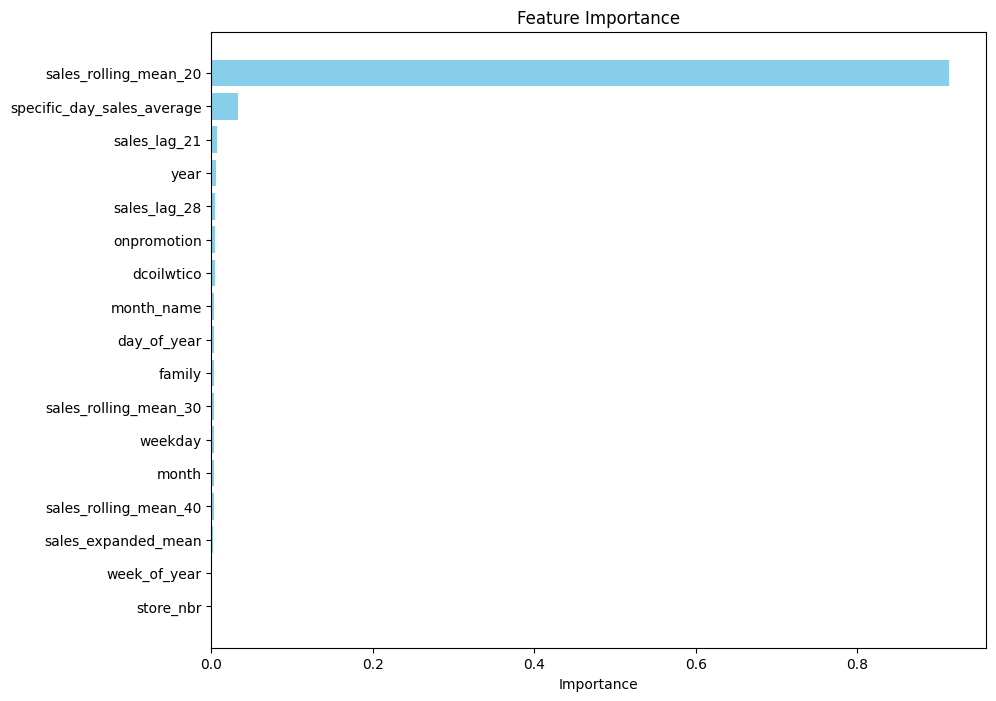

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmsle', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
def plot_feature_importance(model, X_train):
    """
    Plots the feature importance of a model as a horizontal bar graph.

    Parameters:
    model: Trained model with feature_importances_ attribute
    X_train: Training data used for the model
    """
    # Extract feature importances and feature names
    feature_importances = model.feature_importances_
    features = X_train.columns

    # Create a DataFrame for better manipulation
    importance_df = pd.DataFrame(
        {"Feature": features, "Importance": feature_importances}
    )

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Print col names by importance
    print(importance_df["Feature"])

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.show()

# Transform sales column in training dataframe
train_df_log = train_df.copy()
train_df_log["sales"] = np.log(train_df["sales"] + 1)
encode = False
cols_to_exclude = [
    "quarter",
    "weekday_name",
    "city",
    "state",
    "store_type",
    "cluster",
    "test",
    "id",
]

# Create dataset split
X_train, X_test, y_train, y_test = build_training_sets(
    train_df_log, cols_to_exclude, categorical_cols, encode
)

# Initialize XGBoost model
model = XGBRegressor(enable_categorical=True, eval_metric="rmsle")

# Train the model
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Transform predictions back
predictions = np.exp(predictions) - 1
y_test = np.exp(y_test) - 1

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Apply the absolute value function to both y_test and predictions
y_test_abs = abs(y_test)
predictions_abs = abs(predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(mean_squared_log_error(y_test_abs, predictions_abs))

# Calculate the average of the target variable
avg_target = np.mean(y_test)

# Calculate MAE as a percentage of the average target variable value
mae_percentage = (mae / avg_target) * 100

# Create a DataFrame to store results
results = pd.DataFrame(
    {
        "Model": ["XGBoost"],
        "RMSLE": [rmsle],
        "RMSE": [np.sqrt(mse)],
        "MSE": [mse],
        "MAE": [mae],
        "MAE%": [mae_percentage],
    }
).round(2)

results_df = pd.concat([results_df, results], ignore_index=True)

plot_feature_importance(model, X_train)

# Train on entire dataset
X_train, X_test, y_train, y_test = build_training_sets(
    train_df_log, cols_to_exclude, categorical_cols, encode
)
model = XGBRegressor(enable_categorical=True, eval_metric="rmsle")
model.fit(pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0))

## Check the combined model's result

In [17]:
results_df

,Model,RMSLE,RMSE,MSE,MAE,MAE%
0,Linear Regression,2.14,1.300651e+10,1.691693e+20,98538439.94,20187702.68
1,Random Forest,0.55,3.721100e+02,1.384693e+05,92.97,19.05
2,CatBoost,0.50,3.819700e+02,1.459040e+05,87.35,17.90
3,XGBoost,0.52,3.621800e+02,1.311759e+05,87.59,17.95


RMSE measures the average absolute error between predictions and actual values, penalizing larger errors more significantly. Lower values indicate better performance.

Analysis:

*Linear Regression*: RMSE = 1.300651e+10 (very high, the model has large deviations in predictions).

*Random Forest*: RMSE = 3.721100e+02 (good performance).

*CatBoost*: RMSE = 3.819700e+02 (worse than XGBoost and Random Forest, but still acceptable).

*XGBoost*: RMSE = 3.621800e+02 (slightly better than Random Forest).

**Conclusion**: XGBoost has the lowest RMSE, suggesting it produces predictions with smaller absolute deviations.

We'll use this model in order to have a better prediction.

### Create a SHAP TreeExplainer
SHAP (SHapley Additive exPlanations) is a popular algorithm for interpreting machine learning models. 
It provides insights into how each feature contributes to the model's predictions by assigning Shapley values to them.

TreeExplainer is a SHAP-specific tool designed for tree-based models like XGBoost. It efficiently computes Shapley values, enabling us to understand the impact of each feature on the model's predictions, ensuring transparency and interpretability.

We'll use it to enhace the model's interpretability combining its power with reasoning models (such as o1, o3-mini, deep seek, among others).

In [ ]:
from shap import TreeExplainer

explainer = TreeExplainer(model)

## Persist the artifacts

In [ ]:
import pickle

with open("../train/model_artifacts//model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("../train/model_artifacts/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("../train/model_artifacts/explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)